In [1]:

# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"


--2022-01-01 15:35:47--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.85.236.111, 2600:1407:3c00:1086::e59, 2600:1407:3c00:10a2::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.85.236.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  63.9MB/s    in 11s     

2022-01-01 15:35:59 (68.5 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [4]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
base_dir = '/tmp/catsvdogs'

train_dir = os.path.join(base_dir , 'train')
validation_dir = os.path.join(base_dir , 'validation')

train_cat_dir = os.path.join(train_dir,'cats')
train_dog_dir = os.path.join(train_dir , 'dogs')

val_cat_dir = os.path.join(validation_dir ,'cats')
val_dog_dir = os.path.join(validation_dir , 'dogs')



In [6]:
try:
  os.mkdir('/tmp/catsvdogs')
  os.mkdir(train_dir)
  os.mkdir(validation_dir)
  os.mkdir(train_cat_dir)
  os.mkdir(train_dog_dir)
  os.mkdir(val_cat_dir)
  os.mkdir(val_dog_dir)

except OSError:
  pass


In [7]:
def split_data(SOURCE , TRAINING,VALIDATION,SPLIT_SIZE):
  files = []
  for file_name in os.listdir(SOURCE):
    file_ = SOURCE + file_name
    if os.path.getsize(file_) > 0:
      files.append(file_name)
    else:
      print(file_name + ' Is Zero Length So Ignoring')

  training_length = int(len(files)*SPLIT_SIZE)
  validation_length = int(len(files) - training_length)

  shuffle_set = random.sample(files,len(files))
  train_set = shuffle_set[0:training_length]
  val_set = shuffle_set[-validation_length:]

  for train_name in train_set:
    file_source_path = SOURCE + train_name
    destination = TRAINING + train_name
    copyfile(file_source_path , destination)

  for val_name in val_set:
    file_path = SOURCE + val_name
    destination = VALIDATION + val_name
    copyfile(file_path,destination)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/catsvdogs/train/cats/"
VAL_CATS_DIR = "/tmp/catsvdogs/validation/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/catsvdogs/train/dogs/"
VAL_DOGS_DIR = "/tmp/catsvdogs/validation/dogs/"

split_data(CAT_SOURCE_DIR,TRAINING_CATS_DIR,VAL_CATS_DIR,0.9)
split_data(DOG_SOURCE_DIR,TRAINING_DOGS_DIR,VAL_DOGS_DIR,0.9)





666.jpg Is Zero Length So Ignoring
11702.jpg Is Zero Length So Ignoring


## Lets Start To build our Model 
*** Note in this case the images are of different shape and sizes so we have to preprocess the images beofre we pass them on to our model ***

In [8]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16,3,activation = 'relu',input_shape = (150,150,3)),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(32,3,activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(64,3,activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512,activation = 'relu'),
                             tf.keras.layers.Dense(1,activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 0.001),
              metrics = ['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Lets create Image Data Generator object to handle our input Data

In [18]:
# train_dir contains the path to the training directory

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


valid_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 10,
                                                    class_mode = 'binary',
                                                    classes = ['cats','dogs'])

valid_generator = valid_datagen.flow_from_directory(validation_dir,
                                                    target_size = (150,150),
                                                    batch_size = 10,
                                                    classes = ['cats','dogs'],
                                                    class_mode = 'binary',
                                                    shuffle = False)



Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [19]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = 100,
                    epochs = 15,
                    validation_steps = 50
                   )

Epoch 1/15
100/100 [==============================] - 14s 143ms/step - loss: 0.6603 - accuracy: 0.6870 - val_loss: 0.4134 - val_accuracy: 0.8060
Epoch 2/15
100/100 [==============================] - 13s 129ms/step - loss: 0.5986 - accuracy: 0.7084 - val_loss: 0.5531 - val_accuracy: 0.7320
Epoch 3/15
100/100 [==============================] - 13s 129ms/step - loss: 0.5810 - accuracy: 0.7040 - val_loss: 0.4386 - val_accuracy: 0.8180
Epoch 4/15
100/100 [==============================] - 13s 131ms/step - loss: 0.5579 - accuracy: 0.7280 - val_loss: 0.6686 - val_accuracy: 0.6360
Epoch 5/15
100/100 [==============================] - 14s 144ms/step - loss: 0.5595 - accuracy: 0.7030 - val_loss: 0.4204 - val_accuracy: 0.8180
Epoch 6/15
100/100 [==============================] - 13s 134ms/step - loss: 0.5597 - accuracy: 0.7164 - val_loss: 0.4133 - val_accuracy: 0.8440
Epoch 7/15
100/100 [==============================] - 14s 144ms/step - loss: 0.5854 - accuracy: 0.7090 - val_loss: 0.5385 - val_ac

##### Lets try to make the model predict our custom image

In [13]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline


def predictor():

  uploaded = files.upload()

  for fn in uploaded.keys():
    path = '/content/'+ fn

    img = image.load_img(path , target_size = (150,150))
    plt.imshow(img)

    x = image.img_to_array(img)
    x = np.expand_dims(x,axis = 0)

    images = np.vstack([x])

    predict_class = model.predict(images,batch_size  =10)
    print(predict_class[0])

    if predict_class[0]>0:
      print(fn + 'is a dog')
    else:
      print(fn + 'is a cat')

Saving 10.jpg to 10.jpg
[0.]
10.jpgis a cat


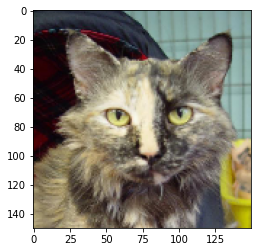

In [25]:
predictor()

#### Lets plot the train and val accuracy

In [ ]:
history.history.keys()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


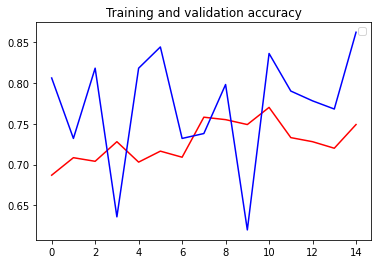

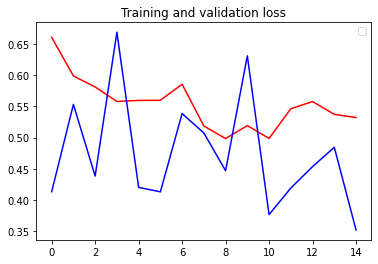

In [22]:
import matplotlib.image as mpimg


acc = history.history['accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

val_accuracy = history.history['val_accuracy']

epochs = range(len(acc))


#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')


plt.title('Training and validation loss')
plt.legend()
# Desired output. Charts with training and validation metrics. No crash :)
